## Analyze A/B Test Results

Hajer aloulah, 2020
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal of this project, is to help the company understand if they should implement the new page, keep the old page, or run the experiment longer before making their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [72]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [73]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [74]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [75]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [76]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [77]:
pd.crosstab(df.group, df.landing_page, margins=True)

landing_page,new_page,old_page,All
group,,,
control,1928,145274,147202
treatment,145311,1965,147276
All,147239,147239,294478


f. Do any of the rows have missing values?

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [79]:
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [80]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [81]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [82]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [83]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [84]:
df2.shape

(290585, 5)

In [85]:
df2 = df2.drop_duplicates(subset='user_id');

In [86]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [87]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [88]:
df2.query('group =="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [89]:
df2.query('group =="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [90]:
len(df2[df2['landing_page'] == 'new_page'])/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The control group has a slightly higher conversion rate (0.1203863045004612) than treatment group (0.11880806551510564). So, that's not sufficient evidence to conclude that the new treatment page leads to more conversions.. maybe I need to calculate p-value for the new and old pages to more information.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$p_{new}$ > $p_{old}$  

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [91]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [92]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [93]:
newPage_df = df2.query('landing_page == "new_page"')
n_new = newPage_df.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [94]:
oldPage_df = df2.query('landing_page == "old_page"')
n_old = oldPage_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [95]:
new_page_converted = np.random.binomial (n_new,p_new)
new_page_converted

17498

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [96]:
old_page_converted = np.random.binomial(n_old,p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [97]:
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

0.0024620024025715226

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [98]:
p_diffs = []

for _ in range(10000):
    new_converted_simulation = np.random.binomial(n_new,p_new)/n_new
    old_converted_simulation = np.random.binomial(n_old,p_old)/n_old
    diff = new_converted_simulation - old_converted_simulation 
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

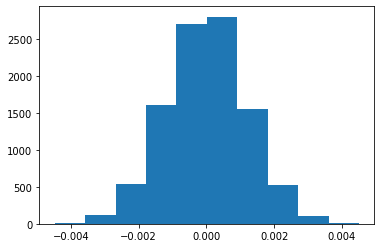

In [99]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [100]:
org_old_mean = df.query('group =="control"').converted.mean()
org_new_mean = df.query('group =="treatment"').converted.mean()
org_diff = org_new_mean - org_old_mean

p_diffs = np.array(p_diffs)

(p_diffs > org_diff).mean()

0.8935

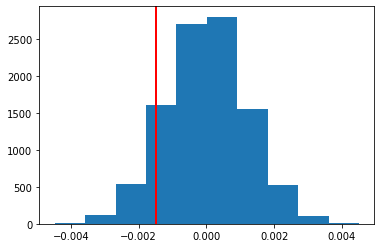

In [101]:
plt.hist(p_diffs);
plt.axvline(org_diff,c='r',linewidth = 2);

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The p-value of observing the statistic given the Null is true..
So, we cant reject the Null hypothesis and keep the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [102]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [103]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Its consistent with the results in parts j & k because z_score is less than value so, its fail to reject the Null.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Its the logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [104]:
df2['intercept']=1

df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

In [105]:
df2['intercept']=1
df2[['ab_page','old_page']]= pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [106]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept','treatment']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [107]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:25:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

p-value = -1.311 ,,
becuase in part II, was performed (one-sided) test.. where in the logistic regression part, it is (two-sided) test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

considering other factors is a good idea as these factors may contribute to the significance of our test results and leads to more accurate decisions.

Yes, it's Simpson's paradox where the combined impact of different variables disappears or reverses when these variables are combined, but appears where these variables are tested individually.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [108]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [109]:
df_new = pd.merge(df2,countries_df,how='inner',on='user_id')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,US


In [110]:
df_new.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [111]:
df_new['intercept'] = 1
df_new[['US', 'CA', 'UK']] = pd.get_dummies(df_new['country'])[['US', 'CA', 'UK']]
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page,country,US,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,US,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,US,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,US,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,US,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,US,1,0,0


In [112]:
countries = pd.read_csv('countries.csv')
countries.head()

df2 = df2.set_index('user_id').join(countries.set_index('user_id'))

In [113]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

In [114]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 23 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:26:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

So, after looking at logit regression result.. can conclude that there is no significant effect of the country on the conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [115]:
df2['CA_page'] = df2['CA']*df2['ab_page']
df2['UK_page'] = df2['UK']*df2['ab_page']
df2['US_page'] = df2['US']*df2['ab_page']
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'CA_page', 'UK_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 23 Aug 2020   Pseudo R-squ.:               2.364e-05
Time:                        19:26:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_page       -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_page        0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

After see logit regression result.. can conclude that there is no significant effect of the country and landing page on the conversion.


So, based on the above, the interpretation for the CA_page coefficient.. Holding all other variables constant, a user from Canada who gets the new page would be about 1.08 times more likely to convert. While this holds a small amount of statistical significance, it does not hold much practical significance.. Since it is also the only value of statistical significance (when ab_page and country were insignificant on their own) it is unlikely to be of any real use to us.
Ultimately, not have enough evidence to reject the null hypothesis based on any of our A/B testing. As a result, there is no reason to switch to the new page, when the old one performs just as well.

<a id='conclusions'></a>
## Conclusion

> Finally, after A/B test by using Null and calculating the Z-score.. Both methods led to the same conclusion which is landing page don't have sigificant effect on the converted rate. Avd in the regression approach, used a logistic regression model. P-value was different from what we got in the A/B test due to different null and alternative hypotheses.. But the result provided by the regression model agreed with the results in the A/B test. Then, in Simpson's Paradox, the country is an additional factor into the regression model. because should looked at the individual factors with the interaction of country and landing page to see effects on conversion. 

> So, all results showed that the factors of landing page and country don't lead to significant effect on the converted rate individually and interactively..